In [68]:
import numpy as np
import probnum as pn
import matplotlib.pyplot as plt

In [69]:
#CHOOSE number of input functions
N = 20

d = 2**12 # grid points

t_left = 0
t_right = 1
t = np.linspace(t_left,t_right,d)

lamb =  1e-4 # regularization parameter

In [97]:
def sin_polin(t,alpha,M):
    return sum((2* np.sin(2*j*np.pi*t) / (j**alpha)) for j in range(1,M+2))

def fourier_expon(t,alpha,M):
    return sum((np.exp(1j*2*k*np.pi*t) / (k**alpha)) for k in range(1,M+2)) + sum((np.exp(1j*2*k*np.pi*t) / (k**alpha)) for k in range(-M,0))





#CHOOSE ground truth function and obs. noise         y_i = x_i * true_w + noise
beta = .4
sum_until = 10  # index of truncation of the fourier series
true_w = fourier_expon(t,beta,sum_until)                        

noise = 0.05

/home/emilia/.local/miniconda3/envs/conv/lib/python3.11/site-packages/matplotlib/cbook.py:1699: ComplexWarning: Casting complex values to real discards the imaginary part
  return math.isfinite(val)
/home/emilia/.local/miniconda3/envs/conv/lib/python3.11/site-packages/matplotlib/cbook.py:1345: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)
/tmp/ipykernel_67677/2255301867.py:14: UserWarning: The figure layout has changed to tight
  plt.tight_layout()


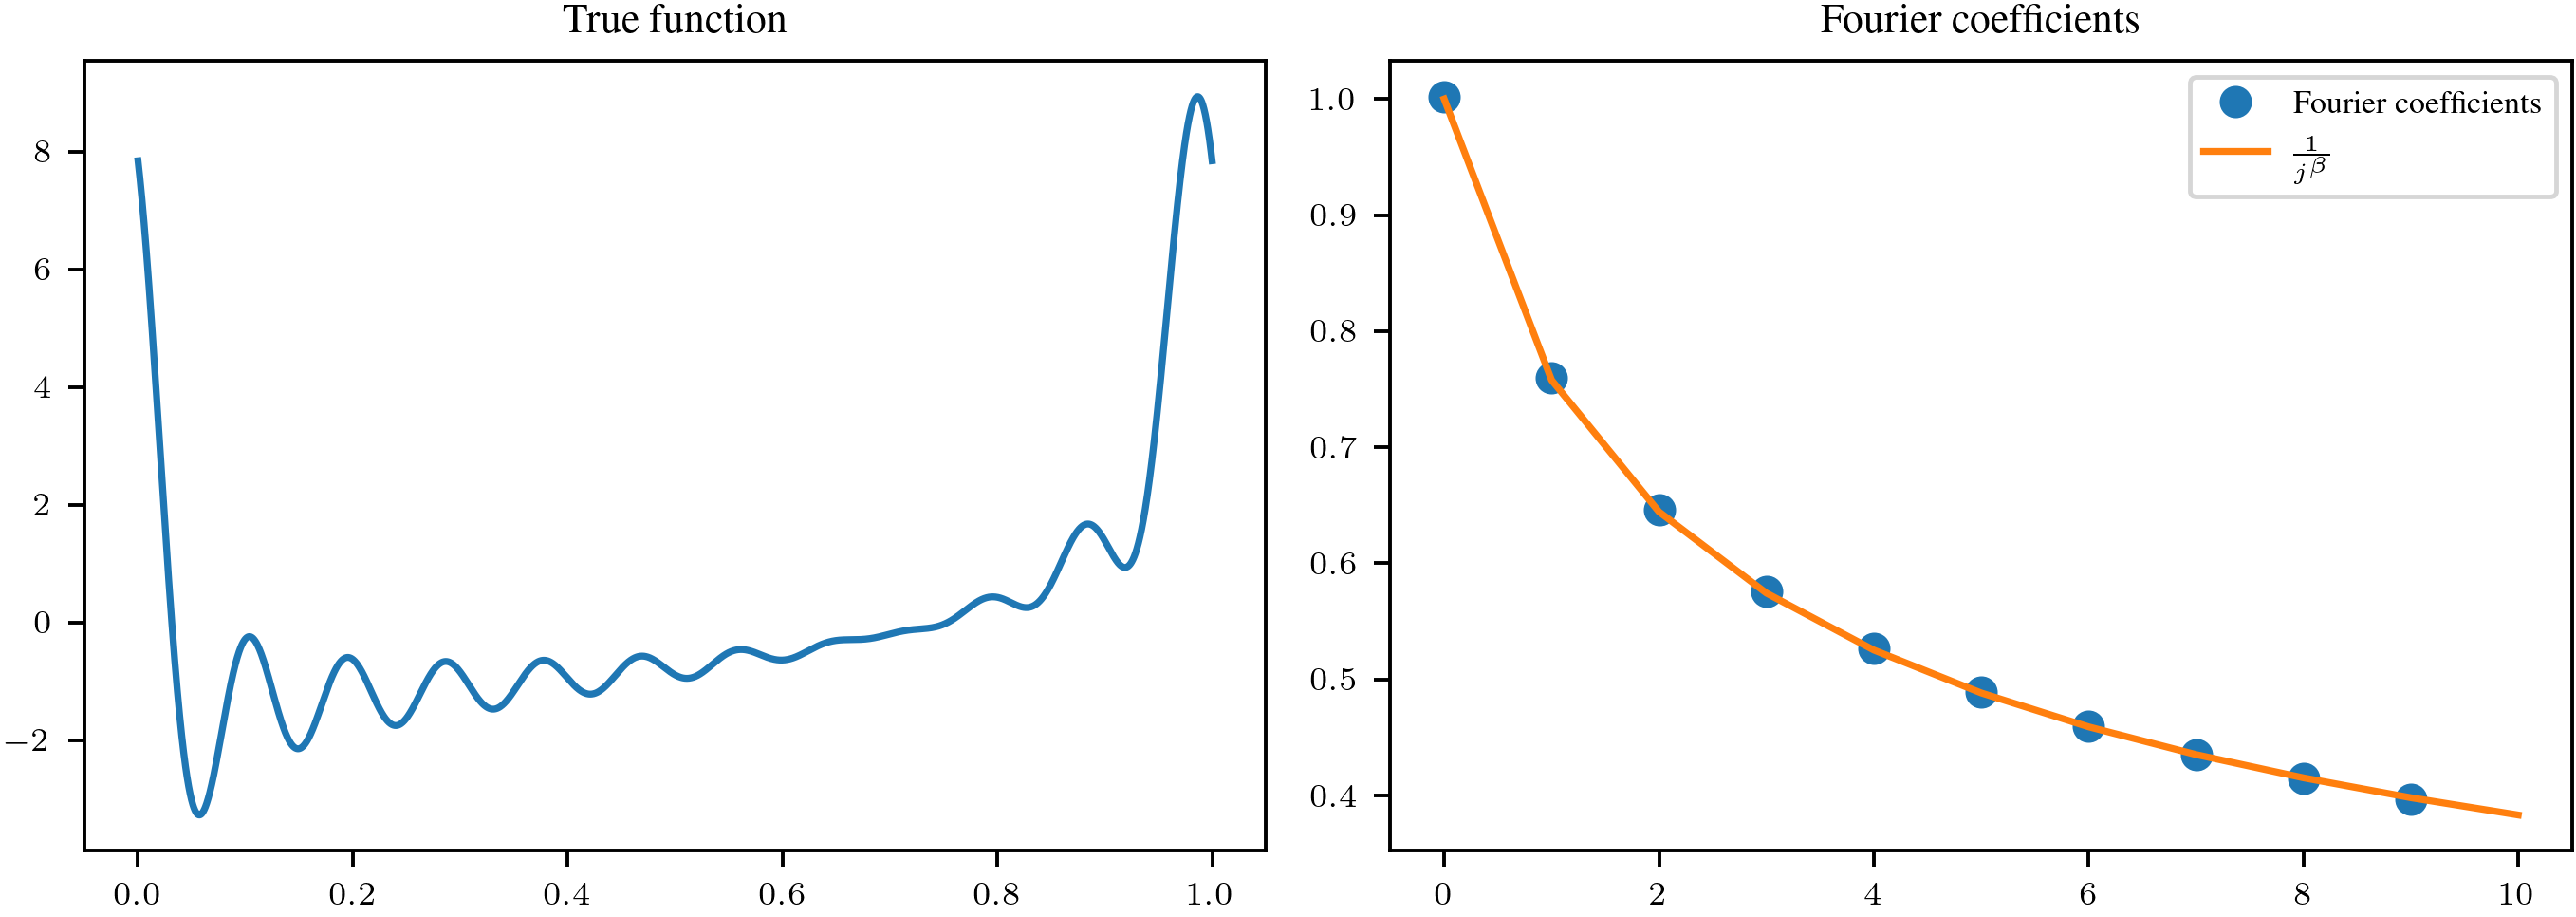

In [102]:
#fourier coefficients of w_true
c = np.fft.fft(true_w)  / t.size  # normalized by the number of grid points


#plot the true function and its fourier coefficients in two subplots
fig,(ax1, ax2)  = plt.subplots(1,2,figsize=(8, 3))
ax1.plot(t,true_w)
ax1.set_title('True function')
ax2.plot(c[1:sum_until+1], 'o', label='Fourier coefficients')
aux_vec=np.arange(1,c.size+1, dtype=float)
ax2.plot(aux_vec[:sum_until+1]**(-beta), label=r'$\frac{1}{j^\beta}$')
ax2.set_title('Fourier coefficients')
ax2.legend()
plt.tight_layout()



In [71]:
# plt.plot(t,true_w)

In [72]:
#To draw samples from the distribution rho_l = l^-beta

def power_law_samples(N, L, alpha):
    """
    Generates N samples drawn from a power law probability distribution on the integers
    with exponent alpha.
    
    Args:
    - N: an integer specifying the number of samples to generate
    -L: the samples are drawn in the interval [1,L+1]
    - alpha: a positive float specifying the exponent of the power law
    
    Returns:
    - A numpy array of N integers drawn from the power law distribution
    """
    # Define the power law probability density function
    def p(x):
        return 1.0 / (x**alpha)
    
    # Define the normalization constant
    Z = sum([p(l) for l in range(1, L+1)])
    
    # Generate the samples
    samples = []
    while len(samples) < N:
        # Choose a random integer in the range [1, L+1] with probability proportional to p(l)
        n = np.random.choice(range(1, L+1), p=[p(l)/Z for l in range(1, L+1)])
        samples.append(n)
    
    return np.array(samples)

In [73]:
### Case 1. Inputs localized in frequency

##random vector for frequencies
L_max = sum_until
# samples_decay = .8
# L = power_law_samples(N, L_max, samples_decay)

# ##Inputs X = [x_1, .., x_N]
# X =  np.array([ np.cos(l*t*2*np.pi) + 1j*np.sin(l*t*2*np.pi)  for l in L]).T


## Case 2. Inputs localized in time

##Gaussian vector 
T = np.random.normal(.5,.2,N)

#Inputs X = [x_1, .., x_N]
delta = 0.076
X = np.array([np.where(((t-l) <= 2*delta) & ((t-l)>=0), 1, 0) for l in T]).T / (2*delta)

In [74]:
#Output data matrix 
Y = np.zeros((d,N))   #noisy 
for i in range(0,N):
    Y[:,i] = np.fft.ifft(d*(np.fft.fft(true_w)/d)*(np.fft.fft(X[:,i])/d)) +  noise  * np.random.normal(0,1,d)
    #parte reale??

/tmp/ipykernel_67677/3051559508.py:4: ComplexWarning: Casting complex values to real discards the imaginary part
  Y[:,i] = np.fft.ifft(d*(np.fft.fft(true_w)/d)*(np.fft.fft(X[:,i])/d)) +  noise  * np.random.normal(0,1,d)


In [75]:
X.shape

(4096, 20)

In [76]:
# fourier coefficients of X, Y and true sol  
X_fourier = np.fft.fft(X, axis=0)  / d 

#take the conjugate of the fourier coefficients of X
X_fourier_conj = np.conj(X_fourier) 

Y_fourier = np.fft.fft(Y,axis=0) / d 
true_w_fourier = np.fft.fft(true_w) / d

In [77]:
#kernel 

def Sobolev_fun(t):
    return 1 + (t**2)*np.pi**2 - np.pi**2*t + (np.pi**2)/6

#kernel function periodic on the torus

def Sobolev_fun_periodic(t):
    return np.where(t<=0, Sobolev_fun(t+1), Sobolev_fun(t))

def periodic(t,sigma=1,ell=1):
    return sigma**2 * np.exp( -2*(np.sin(np.pi*np.abs(t)))**2 / ell**2 )

def Dirichlet(t,p):
    return (2*p + 1)* ( np.sinc( (2*p + 1) * (t)  ) / np.sinc(t) )

p= sum_until
kernel_coeff = np.fft.fft(Dirichlet(t,p)) / d

In [78]:
# plt.plot(kernel_coeff,'o')

In [79]:
w_fourier = np.zeros(t.size, dtype=np.complex128)

# for l in range(t.size):
#     nominator = (X_fourier_conj[l,:] * Y_fourier[l,:]).sum() / N
#     denominator = (np.abs(X_fourier[l,:])**2).sum() / N + lamb * (1 / kernel_coeff[l])
#     w_fourier[l] = nominator / denominator

for l in range(t.size):
    gamma = kernel_coeff[l] * (np.abs(X_fourier[l,:])**2).sum() / N
    term1 = kernel_coeff[l] / (gamma + lamb)
    term2 = (X_fourier_conj[l,:] * Y_fourier[l,:]).sum() / N

    w_fourier[l] = term1 * term2



In [80]:
w = np.fft.ifft(w_fourier * d ) 

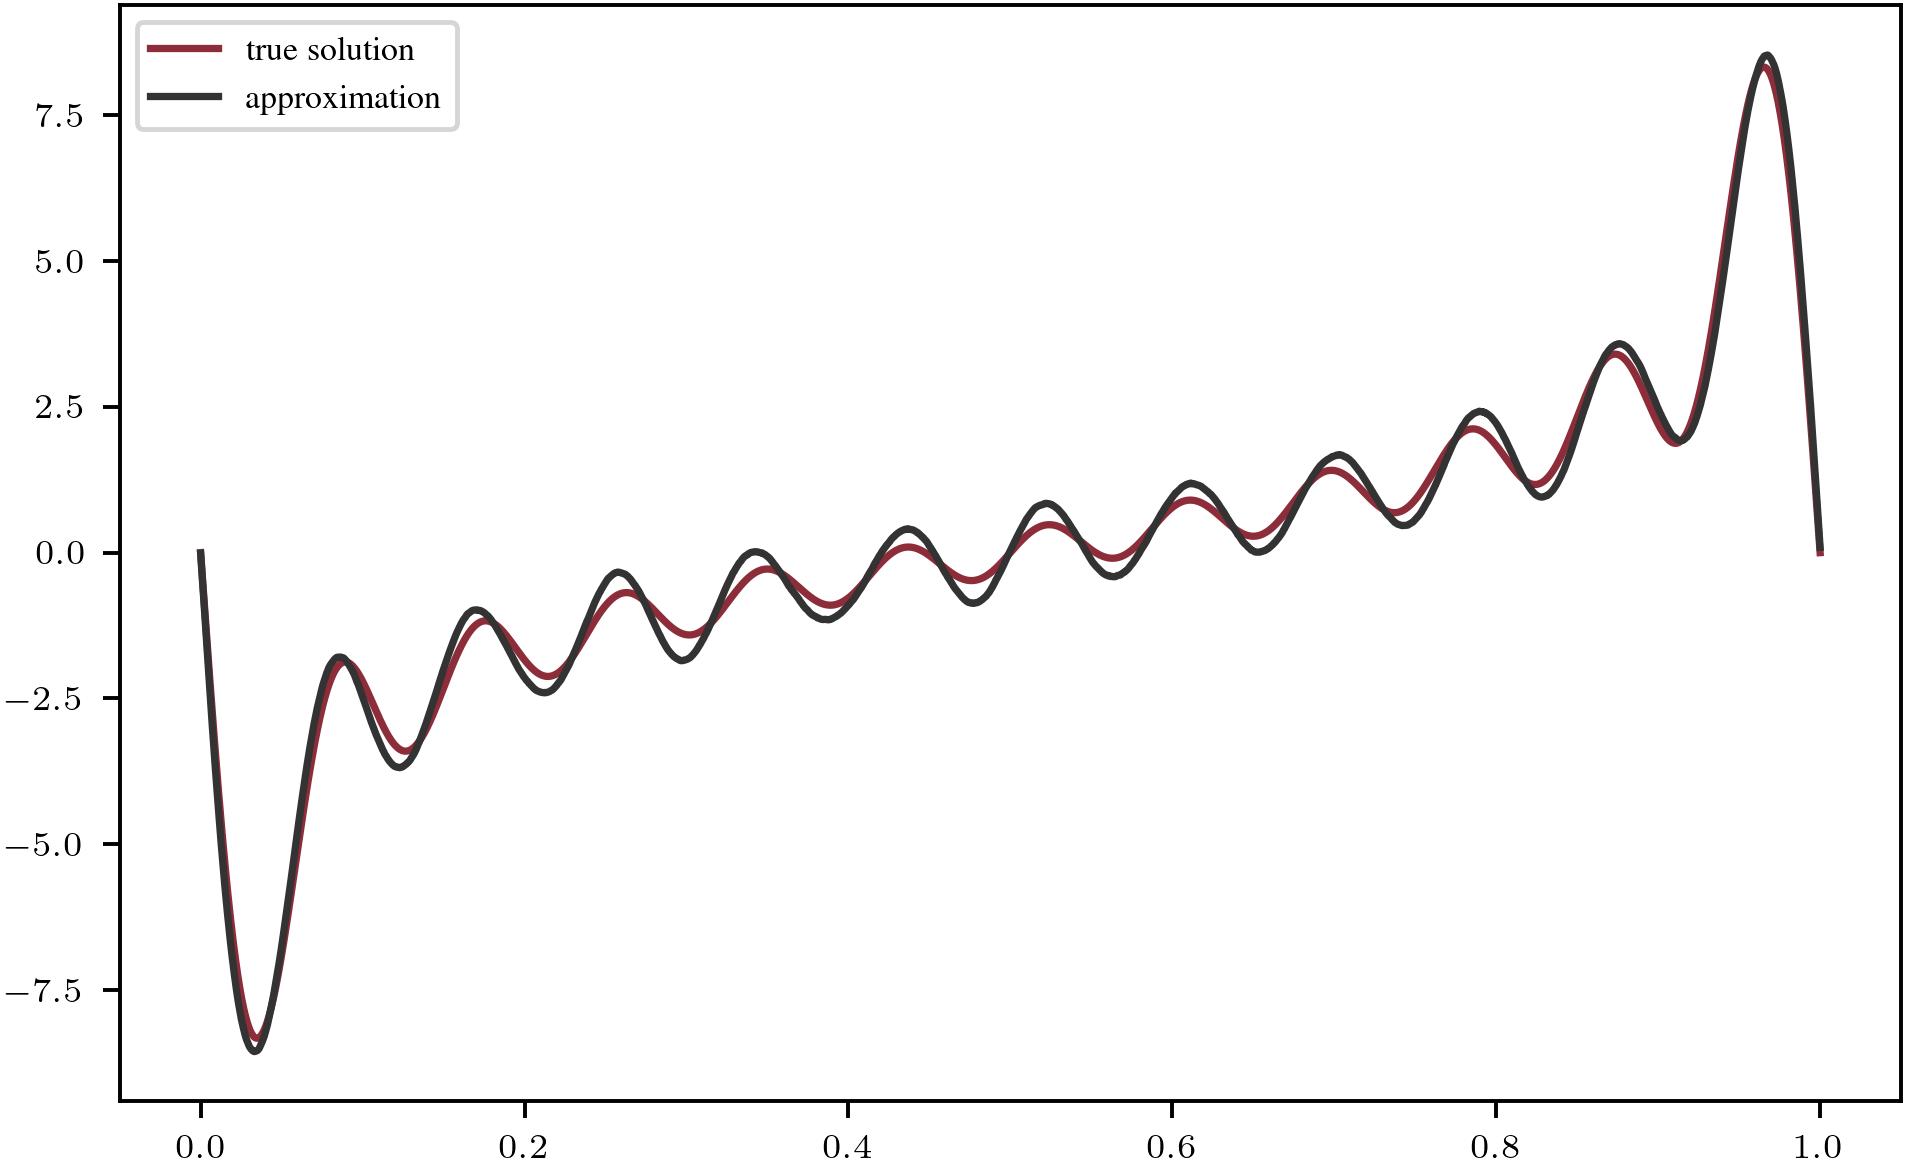

In [81]:
from tueplots import  bundles
plt.rcParams.update(bundles.neurips2023())
plt.rcParams.update({"figure.dpi": 350})


#define colors
red = np.array([141.0, 45.0, 57.0]) / 255.0
dark = np.array([51.0, 51.0, 51.0]) / 255.0

#plot true solution and w
fig, ax = plt.subplots(1, )
ax.plot(t, true_w, label='true solution', color = red)
ax.plot(t, w , label='approximation', color = dark)
ax.legend()


In [82]:
w_diff = w - true_w
w_didd_coeff = np.fft.fft(w_diff) / d
error_h = np.sqrt((np.abs(w_diff)**2 / np.abs(kernel_coeff)).sum())

In [83]:
error_h

195.40082683858603